In [19]:

import gridworlds           # import to trigger registration of the environment
import gymnasium as gym
import numpy as np

# create instance
env = gym.make("gridworld-v0")
env.reset()

(array([0, 0]), {})

In [20]:
"""
Copied from the gridworlds package, because direct access to the environment is not possible,
this is for calculating rewards without changing the environment.
"""
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3


def step_simulation(state, action: np.integer) -> tuple[np.ndarray, float, bool, bool, dict]:
       
        row, col = state  # Current position
        reward = get_reward(state, action)  # Calculate reward

        # Check for teleportation conditions based on special grid positions
        if row == 0 and col == 1:
            row, col = [4, 1]  # Teleport from (0, 1) to (4, 1)
        elif row == 0 and col == 3:
            row, col = [2, 3]  # Teleport from (0, 3) to (2, 3)
        else:
            # Update position based on action
            if action == UP:
                row = max(row - 1, 0)
            elif action == DOWN:
                row = min(row + 1, 5 - 1)
            elif action == RIGHT:
                col = min(col + 1, 5 - 1)
            elif action == LEFT:
                col = max(col - 1, 0)

        new_state = np.array([row, col])  # New position after action
        

        return new_state, reward, False, False, {}

def get_reward(state: np.ndarray, action: np.integer) -> float:
        row, col = state  # Current position
        # Define the size of the grid and initialize the reward matrix
        n = 5
        reward_matrix = np.zeros([n, n])
        reward_matrix[0, 1] = 10  # Positive reward at position (0, 1)
        reward_matrix[0, 3] = 5  # Positive reward at position (0, 3)
        reward = reward_matrix[row, col]  # Base reward from reward matrix

        # Apply penalty if attempting to move outside borders
        if at_border(state) and reward == 0:
            if row == 0 and action == UP:
                reward = -1.0
            if row == 5 - 1 and action == DOWN:
                reward = -1.0
            if col == 0 and action == LEFT:
                reward = -1.0
            if col == 5 - 1 and action == RIGHT:
                reward = -1.0

        return reward

def at_border(state) -> bool:
    # Check if the agent is at the border of the grid
    row, col = state
    return row == 0 or row == 5 - 1 or col == 0 or col == 5 - 1



In [21]:
import matplotlib.pyplot as plt
class Policy:
    def __init__(self):
        self.policy = np.full((5, 5, 4), 0.25)
        

    def act(self, state):
        return np.random.choice(4, p=self.policy[state[0], state[1]])
    
    def update(self, state, action):
        self.policy[state[0], state[1]] = np.zeros(4)
        self.policy[state[0], state[1], action] = 1
    
    def improve(self, V, gamma = 0.8):
        for x in range(5):
            for y in range(5):
                state = (x, y)
                default = False
                if np.all(self.policy[x, y] == 0.25):
                    default = True
                old_action = np.argmax(self.policy[x, y]) # greedy choice
                action_values = np.zeros(4)
                for i in range(self.policy.shape[2]):
                    next_state, reward, _, _, _  = step_simulation(state, i)
                    action_values[i] = reward + gamma * V[next_state[0], next_state[1]]
                best_action = np.argmax(action_values)
                self.update(state, best_action)
                if old_action != best_action or default:
                    return False # policy changed
        return True # policy did not change
    

In [22]:
class PolicyEvaluation:
    def __init__(self, env, policy, gamma=0.8, theta=0.1):
        self.env = env
        self.policy = policy
        self.gamma = gamma
        self.theta = theta
      
        
    def evaluate(self):
        delta = 1
        V = np.zeros((5, 5))
        iterations = 0
        while delta >= self.theta:
            iterations += 1
            delta = 0
            for x in range(5):
                for y in range(5):
                    state = (x, y)
                    v = V[x, y]
                    temp_v = 0
                    for i in range(self.policy.policy.shape[2]):
                        next_state, reward, _, _, _ = step_simulation(state, i)
                        temp_v += self.policy.policy[x, y, i] * (reward + self.gamma * V[next_state[0], next_state[1]])
                    V[x, y] = temp_v
                    delta = max(delta, abs(v - V[x, y]))
        return V , iterations
    
    

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gridworld(final_value, final_policy):
    fig, ax = plt.subplots()
    im = ax.imshow(final_value, cmap='viridis')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, round(final_value[i, j], 2),
                        ha="center", va="center", color="w")

    ax.set_title("5x5 Gridworld Value Function")
    fig.tight_layout()
    plt.show()
    policy_arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}

    fig, ax = plt.subplots()
    ax.imshow(final_value, cmap='viridis')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            best_action = np.argmax(final_policy[i, j])
            text = ax.text(j, i, policy_arrows[best_action],
                        ha="center", va="center", color="w")

    ax.set_title("5x5 Gridworld Optimal Policy")
    fig.tight_layout()
    plt.show()

In [24]:
class GPI:
    def __init__(self, env, policy, gamma=0.8):
        self.env = env
        self.policy = policy
        self.gamma = gamma
    

    def improve_policy(self):
        ev = PolicyEvaluation(self.env, self.policy).evaluate()
        V = ev[0]
        iterations_eval = ev[1]
        iterations_improvement = 0
        while not self.policy.improve(V, self.gamma):
            ev = PolicyEvaluation(self.env, self.policy).evaluate()
            V = ev[0]
            iterations_eval += ev[1]
            iterations_improvement += 1
        return self.policy.policy , iterations_eval, iterations_improvement

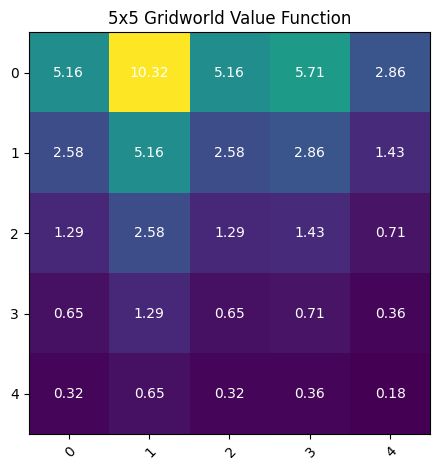

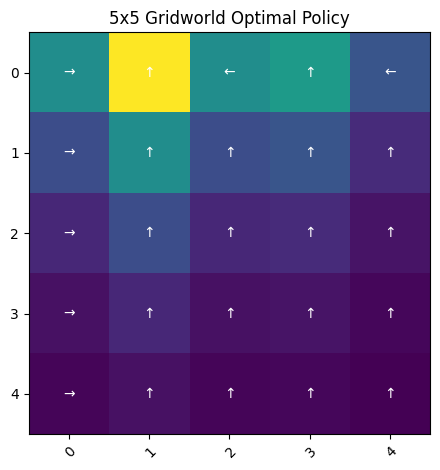

Total number of iterations for policy evaluation: 232, Total number of iterations for policy improvement: 36


In [25]:
p = Policy()
Evaluation = PolicyEvaluation(env, p, 0.5)
Improvement = GPI(env, p, 0.5)
final_policy = Improvement.improve_policy()
final_value = Evaluation.evaluate()
plot_gridworld(final_value[0], final_policy[0])
print(f'Total number of iterations for policy evaluation: {final_policy[1]}, Total number of iterations for policy improvement: {final_policy[2]}')

In [26]:
import time
from IPython.display import display, clear_output

class PolicyValueIteration:
    def __init__(self, env, policy=Policy(), gamma=0.5, theta=0.1):
        self.env = env
        self.policy = policy
        self.gamma = gamma
        self.theta = theta

    def value_iteration(self):
        delta = 1
        V = np.zeros((5, 5))
        stable = False
        iterations = 0
        while delta >= self.theta or not stable:
            iterations += 1
            delta = 0
            for x in range(5):
                for y in range(5):
                    state = (x, y)
                    v = V[x, y]
                    action_values = np.zeros(4)
                    for i in range(self.policy.policy.shape[2]):
                        next_state, reward, _, _, _ = step_simulation(state, i)
                        action_values[i] = reward + self.gamma * V[next_state[0], next_state[1]]
                    V[x, y] = np.max(action_values)
                    delta = max(delta, abs(v - V[x, y]))
            stable = self.policy.improve(V, self.gamma)
            
            # Dynamically update the plot
            clear_output(wait=True)
            plot_gridworld(V, self.policy.policy)
            display(plt.gcf())
            time.sleep(0.05)
            
        return V, iterations

<Figure size 640x480 with 0 Axes>

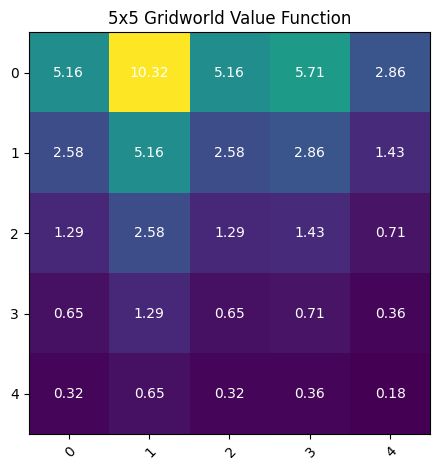

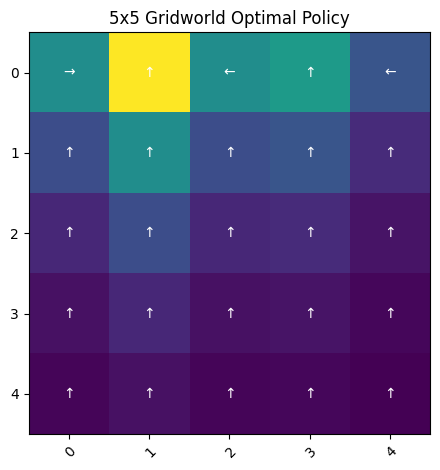

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

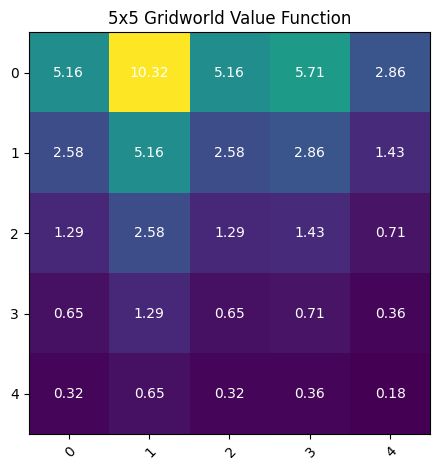

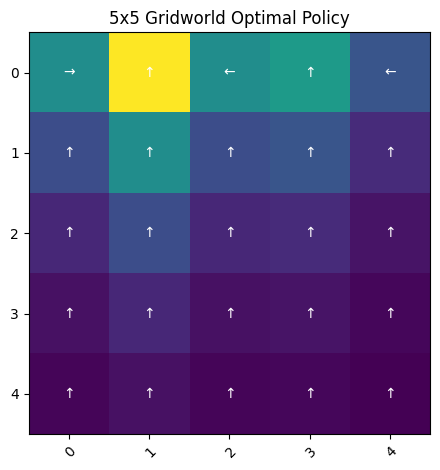

Total number of iterations for policy evaluation + improvement: 28


In [27]:
PV = PolicyValueIteration(env)
values = PV.value_iteration()
final_value = values[0]
plot_gridworld(final_value, PV.policy.policy)
print(f'Total number of iterations for policy evaluation + improvement: {values[1]}')

## Analysis
The GPI Algorithm takes 232 iterations for the evaluation and 36 iterations for policy improvement (25 iterations are the minimum here, as the default policy is probabilistic and every state has to be updated at least once to be deterministic).

With Value Iteration, only a total of 28 iterations of combined evaluation + improvement are needed, with 25 iterations being the minimum again. This approach delivers the same output as the GPI algorithm while only requiring about 10% of the iterations, making it much more effective.